Importing the dependencies

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from scipy.stats import randint, uniform
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, IsolationForest, BaggingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error, accuracy_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from xgboost import callback
from xgboost import XGBRegressor
from xgboost import XGBClassifier
from xgboost.callback import EarlyStopping
from sklearn.datasets import make_regression
from scipy import stats

In [ ]:
pip install -U scikit-learn

In [ ]:
pip install xgboost

In [ ]:
pip install --upgrade xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.9/253.9 MB 5.4 MB/s eta 0:00:00
  Attempting uninstall: xgboost
    Found existing installation: xgboost 2.1.4
    Uninstalling xgboost-2.1.4:
      Successfully uninstalled xgboost-2.1.4


Data Collection and Processing

In [ ]:
data = pd.read_csv("/content/ElectricCarData_Norm.csv")
print(data)

           Brand                            Model     Accel  TopSpeed   Range  \
0         Tesla     Model 3 Long Range Dual Motor   4.6 sec  233 km/h  450 km   
1    Volkswagen                         ID.3 Pure  10.0 sec  160 km/h  270 km   
2      Polestar                                 2   4.7 sec  210 km/h  400 km   
3           BMW                              iX3    6.8 sec  180 km/h  360 km   
4         Honda                                e    9.5 sec  145 km/h  170 km   
..           ...                              ...       ...       ...     ...   
98       Nissan                       Ariya 63kWh   7.5 sec  160 km/h  330 km   
99         Audi     e-tron S Sportback 55 quattro   4.5 sec  210 km/h  335 km   
100      Nissan               Ariya e-4ORCE 63kWh   5.9 sec  200 km/h  325 km   
101      Nissan   Ariya e-4ORCE 87kWh Performance   5.1 sec  200 km/h  375 km   
102       Byton                 M-Byte 95 kWh 2WD   7.5 sec  190 km/h  400 km   

    Efficiency FastCharge  

Dimensions of the dataset

In [ ]:
print("Initial data shape:", data.shape)
print("\nFirst 5 rows:\n", data.head())
print("\nData types:\n", data.dtypes)
print("\nMissing values:\n", data.isnull().sum())

Initial data shape: (103, 14)

First 5 rows:
          Brand                          Model     Accel  TopSpeed   Range  \
0       Tesla   Model 3 Long Range Dual Motor   4.6 sec  233 km/h  450 km   
1  Volkswagen                       ID.3 Pure  10.0 sec  160 km/h  270 km   
2    Polestar                               2   4.7 sec  210 km/h  400 km   
3         BMW                            iX3    6.8 sec  180 km/h  360 km   
4       Honda                              e    9.5 sec  145 km/h  170 km   

  Efficiency FastCharge              RapidCharge        PowerTrain  \
0  161 Wh/km   940 km/h  Rapid charging possible   All Wheel Drive   
1  167 Wh/km   250 km/h  Rapid charging possible  Rear Wheel Drive   
2  181 Wh/km   620 km/h  Rapid charging possible   All Wheel Drive   
3  206 Wh/km   560 km/h  Rapid charging possible  Rear Wheel Drive   
4  168 Wh/km   190 km/h  Rapid charging possible  Rear Wheel Drive   

     PlugType  BodyStyle Segment  Seats  PriceEuro  
0  Type 2 CCS    

****

CHECK DATA TYPES AND USE ONE HOT ENCODING

---



In [ ]:
print(data.dtypes)

Brand          object
Model          object
Accel          object
TopSpeed       object
Range          object
Efficiency     object
FastCharge     object
RapidCharge    object
PowerTrain     object
PlugType       object
BodyStyle      object
Segment        object
Seats           int64
PriceEuro       int64
dtype: object


Remove the units in columns and apply one - hot encoding

In [ ]:
def remove_units(value):
    """Remove units from values and convert to float, handling edge cases."""
    try:
        if pd.isna(value):
            return np.nan
        if isinstance(value, (int, float)):
            return float(value)

        if isinstance(value, str) and '%' in value:
            cleaned = re.sub(r'[^0-9.-]', '', value)
            return float(cleaned) / 100 if cleaned else np.nan

        cleaned = re.sub(r'[^\d.-]', '', str(value))
        return float(cleaned) if cleaned else np.nan
    except (ValueError, TypeError):
        return np.nan

num_cols = ['Accel', 'TopSpeed', 'Range', 'Efficiency', 'FastCharge', 'Seats', 'PriceEuro']
existing_num_cols = [col for col in num_cols if col in data.columns]

for col in existing_num_cols:
    data[col] = data[col].apply(remove_units)

    if col == 'Efficiency' and data[col].max() > 1:
        data[col] = data[col] / 100

if existing_num_cols:
    num_imputer = SimpleImputer(strategy='median')
    data[existing_num_cols] = num_imputer.fit_transform(data[existing_num_cols])

categorical_columns = ['Brand', 'Model', 'RapidCharge', 'PowerTrain', 'PlugType', 'BodyStyle', 'Segment']
existing_cat_cols = [col for col in categorical_columns if col in data.columns]

if existing_cat_cols:
    for col in existing_cat_cols:
        freq_encoding = data[col].value_counts(normalize=True)
        data[col] = data[col].map(freq_encoding)

final_df = pd.concat([
    data[existing_num_cols],
    data[existing_cat_cols]
], axis=1)

print("\nData Summary:")
print(f"Original shape: {data.shape}")
print(f"Processed shape: {final_df.shape}")

print("\nMissing values after processing:")
print(final_df.isna().sum().sum(), "missing values remaining")

print("\nSample of processed numerical columns:")
print(final_df[existing_num_cols].head(3) if existing_num_cols else "No numerical columns processed")

print("\nSample of encoded categorical columns:")
encoded_cat_cols = [col for col in final_df.columns if any(x in col for x in existing_cat_cols)]
print(encoded_cat_cols[:5] if encoded_cat_cols else "No categorical columns encoded")

print("\nFirst 3 rows of final data:")
print(final_df.head(3))


Data Summary:
Original shape: (103, 14)
Processed shape: (103, 14)

Missing values after processing:
0 missing values remaining

Sample of processed numerical columns:
   Accel  TopSpeed  Range  Efficiency  FastCharge  Seats  PriceEuro
0    4.6     233.0  450.0        1.61       940.0    5.0    55480.0
1   10.0     160.0  270.0        1.67       250.0    5.0    30000.0
2    4.7     210.0  400.0        1.81       620.0    5.0    56440.0

Sample of encoded categorical columns:
['Brand', 'Model', 'RapidCharge', 'PowerTrain', 'PlugType']

First 3 rows of final data:
   Accel  TopSpeed  Range  Efficiency  FastCharge  Seats  PriceEuro     Brand  \
0    4.6     233.0  450.0        1.61       940.0    5.0    55480.0  0.126214   
1   10.0     160.0  270.0        1.67       250.0    5.0    30000.0  0.077670   
2    4.7     210.0  400.0        1.81       620.0    5.0    56440.0  0.009709   

      Model  RapidCharge  PowerTrain  PlugType  BodyStyle   Segment  
0  0.009709     0.951456    0.39805

**Adjust** **outliers**

In [ ]:
def adjust_outliers_iqr(df):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df.clip(lower=lower_bound, upper=upper_bound, axis=1)

**Univariate Analysis**

In [ ]:
def univariate_summary(data):
    summary = pd.DataFrame({
        'Feature': data.columns,
        'Count': data.count(),
        'Missing': data.isnull().sum(),
        'Mean': data.mean(),
        'Median': data.median(),
        'Std Dev': data.std(),
        'Min': data.min(),
        'Max': data.max(),
        'Skewness': data.skew(),
        'Kurtosis': data.kurt()
    }).reset_index(drop=True)
    return summary

GridSearchCV

In [ ]:
def gridsearch_cv(model, param_grid, X_train, y_train, cv=5, scoring='r2', n_jobs=-1):
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=cv,
        scoring=scoring,
        n_jobs=n_jobs
    )

    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_

    return best_model, best_params, best_score

**Separating the features and target**

=== Univariate Summary ===
                    Brand       Model       Accel    TopSpeed       Range  \
Null_Count       0.000000    0.000000    0.000000    0.000000    0.000000   
NonNull_Count  103.000000  103.000000  103.000000  103.000000  103.000000   
Total_Count    103.000000  103.000000  103.000000  103.000000  103.000000   
Mean             0.055896    0.009897    7.396117  179.194175  338.786408   
Median           0.048544    0.009709    7.300000  160.000000  340.000000   
Mode             0.077670    0.009709    9.000000  150.000000  250.000000   
STD              0.036339    0.001346    3.017430   43.573030  126.014444   
Min              0.009709    0.009709    2.100000  123.000000   95.000000   
Q1:25%           0.029126    0.009709    5.100000  150.000000  250.000000   
Q2:50%           0.048544    0.009709    7.300000  160.000000  340.000000   
Q3:75%           0.077670    0.009709    9.000000  200.000000  400.000000   
Q4:100%          0.126214    0.019417   22.400000

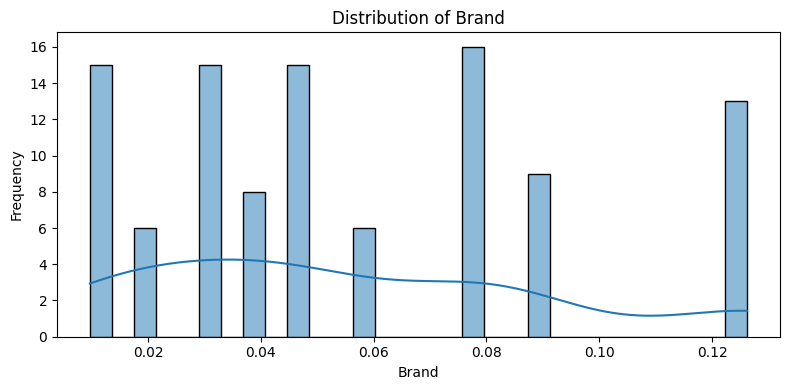

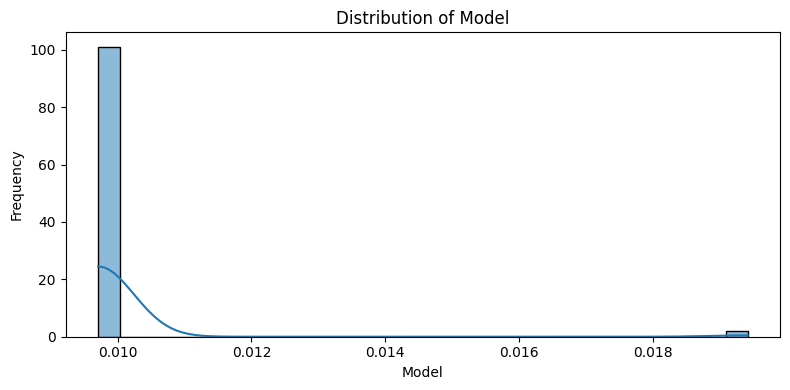

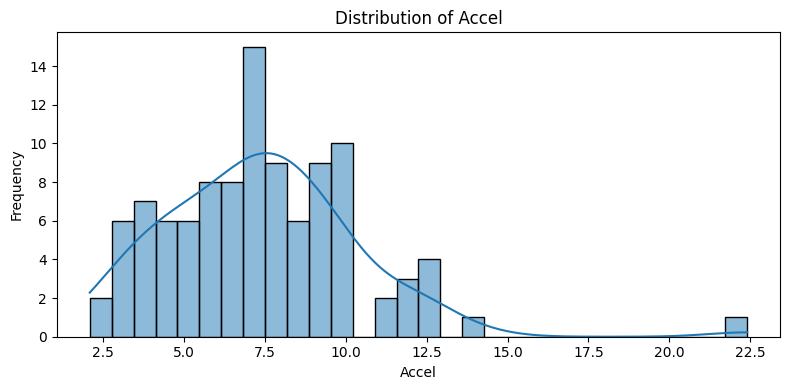

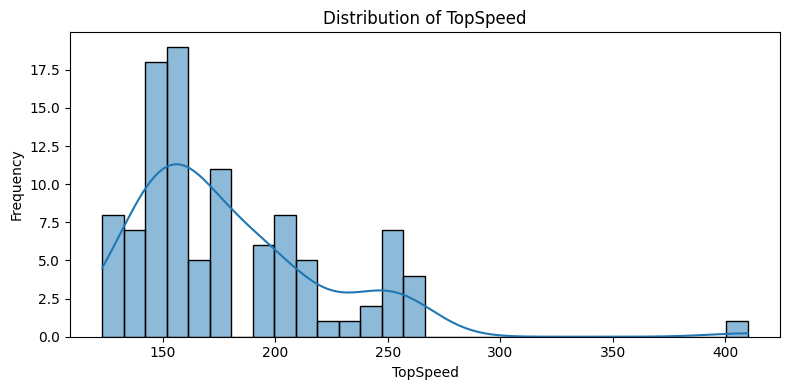

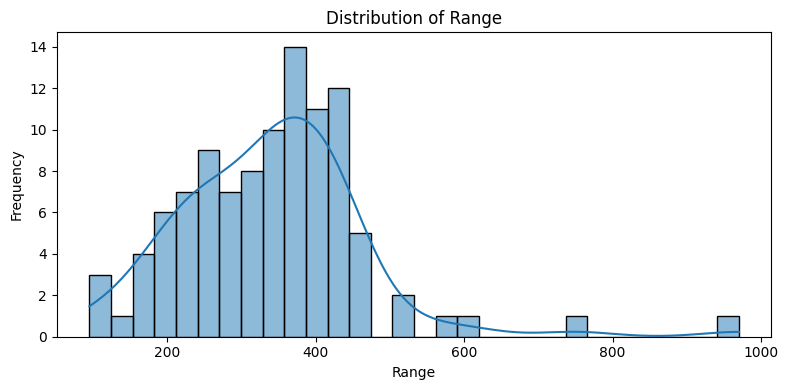

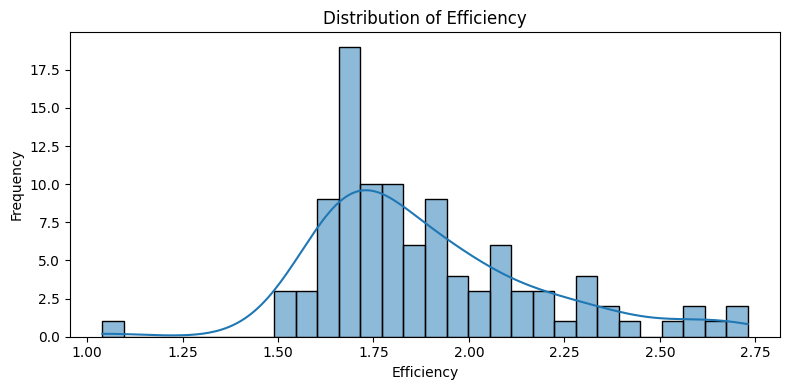

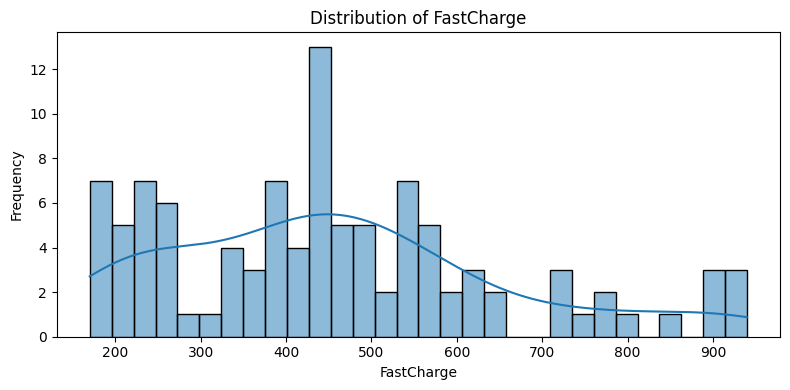

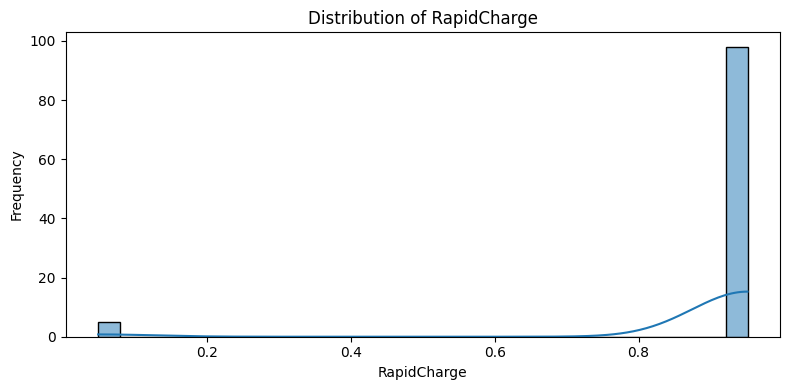

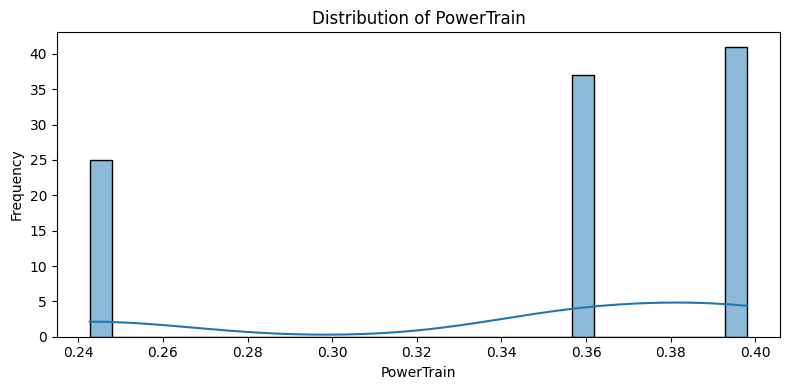

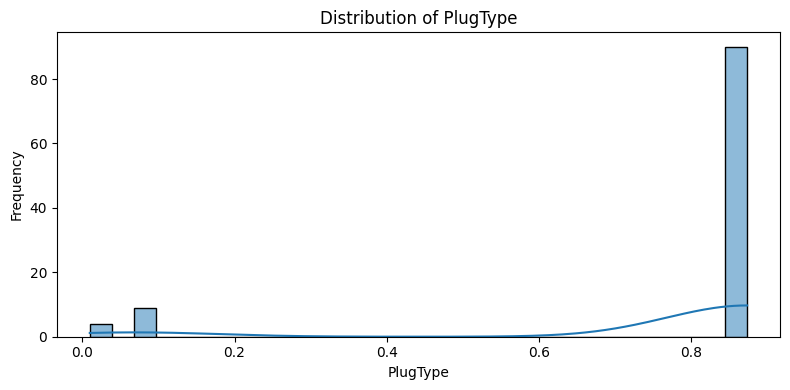

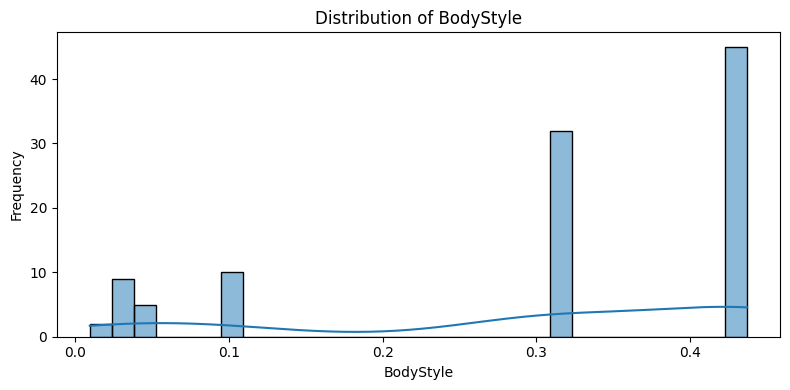

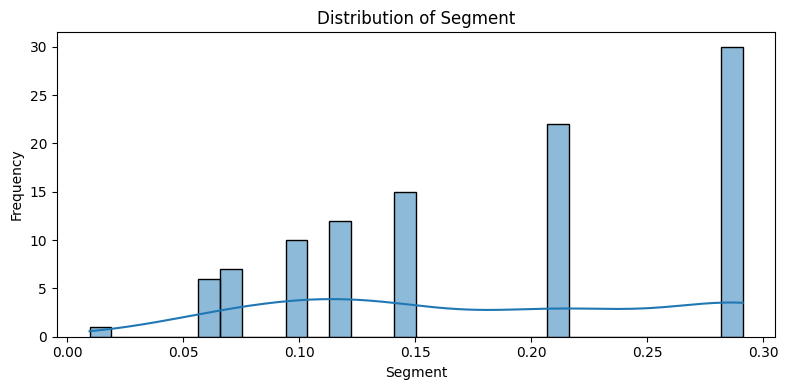

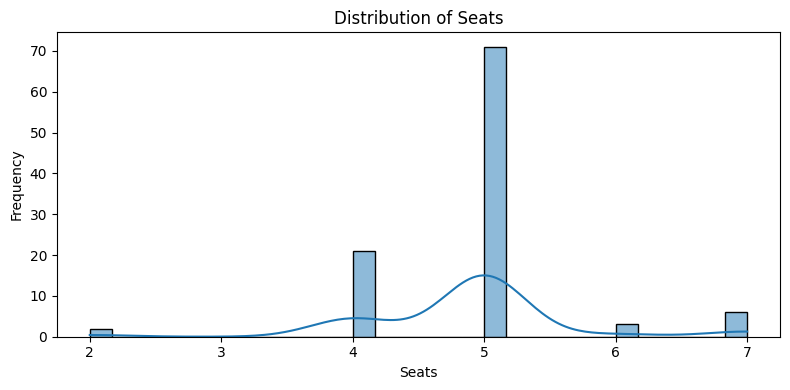

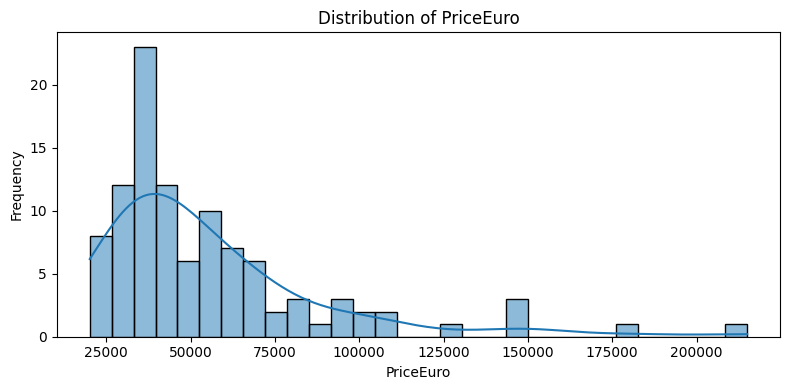

In [ ]:
def univariate_summary(df):
    summary = pd.DataFrame(index=df.columns)

    summary['Null_Count'] = df.isnull().sum()
    summary['NonNull_Count'] = df.notnull().sum()
    summary['Total_Count'] = df.shape[0]

    summary['Mean'] = df.mean()
    summary['Median'] = df.median()
    summary['Mode'] = df.mode().iloc[0]
    summary['STD'] = df.std()
    summary['Min'] = df.min()

    Q1 = df.quantile(0.25)
    Q2 = df.quantile(0.5)
    Q3 = df.quantile(0.75)
    Q4 = df.quantile(1.0)

    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    summary['Q1:25%'] = Q1
    summary['Q2:50%'] = Q2
    summary['Q3:75%'] = Q3
    summary['Q4:100%'] = Q4
    summary['IQR'] = IQR
    summary['1.5 Rule'] = 1.5 * IQR

    summary['Lesser'] = (df < lower_bound).sum()
    summary['Greater'] = (df > upper_bound).sum()

    return summary.T

df_numeric = data.select_dtypes(include=[np.number])
summary_table = univariate_summary(df_numeric)

print("=== Univariate Summary ===")
print(summary_table)

for col in df_numeric.columns:
    plt.figure(figsize=(8, 4))
    sns.histplot(df_numeric[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

summary_table.to_csv("univariate_summary.csv")

In [ ]:
pip install ydata-profiling

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.1/400.1 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 687.8/687.8 kB 30.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.4/105.4 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 kB 3.0 MB/s eta 0:00:00
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27081 sha256=b83294b96a41f11cc57300d5b3292bd80f1b21144cc2cf23002153279e0565bc
  Stored in directory: /root/.cache/pip/wheels/8d/55/1a/19cd535375ed1ede0c996405ebffe34b196d78e2d9545723a2
Successfully built htmlmin


In [ ]:
from ydata_profiling import ProfileReport

df = pd.read_csv("univariate_summary.csv")
profile = ProfileReport(df, title="Univariate Summary", explorative=True)
profile.to_file("summary_report.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 15/15 [00:00<00:00, 57.37it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

=== Univariate Summary ===
                    Brand       Model       Accel    TopSpeed       Range  \
Null_Count       0.000000    0.000000    0.000000    0.000000    0.000000   
NonNull_Count  103.000000  103.000000  103.000000  103.000000  103.000000   
Total_Count    103.000000  103.000000  103.000000  103.000000  103.000000   
Mean             0.055896    0.009897    7.396117  179.194175  338.786408   
Median           0.048544    0.009709    7.300000  160.000000  340.000000   
Mode             0.077670    0.009709    9.000000  150.000000  250.000000   
STD              0.036339    0.001346    3.017430   43.573030  126.014444   
Min              0.009709    0.009709    2.100000  123.000000   95.000000   
Q1:25%           0.029126    0.009709    5.100000  150.000000  250.000000   
Q2:50%           0.048544    0.009709    7.300000  160.000000  340.000000   
Q3:75%           0.077670    0.009709    9.000000  200.000000  400.000000   
Q4:100%          0.126214    0.019417   22.400000

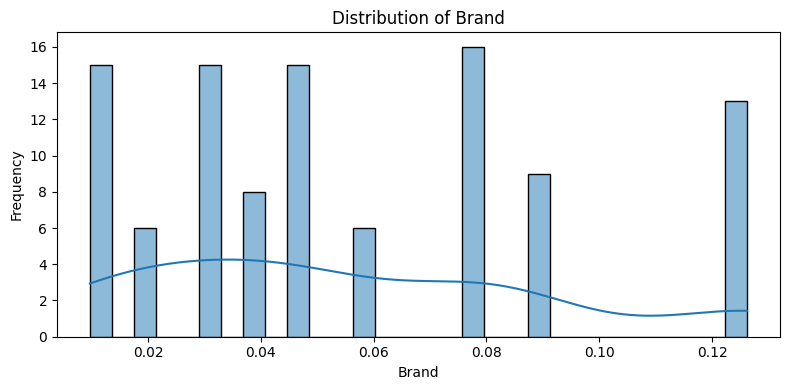

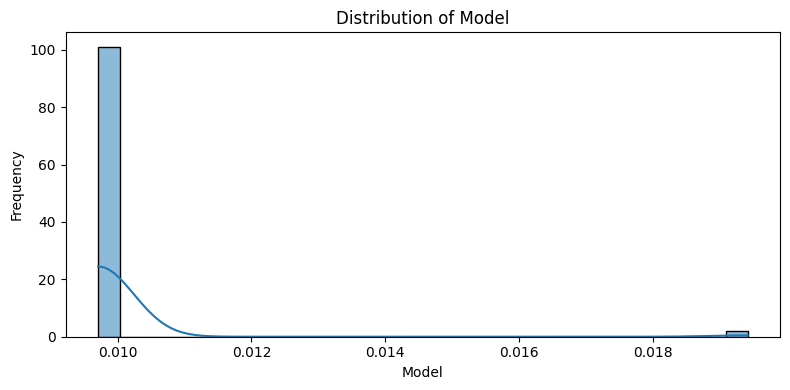

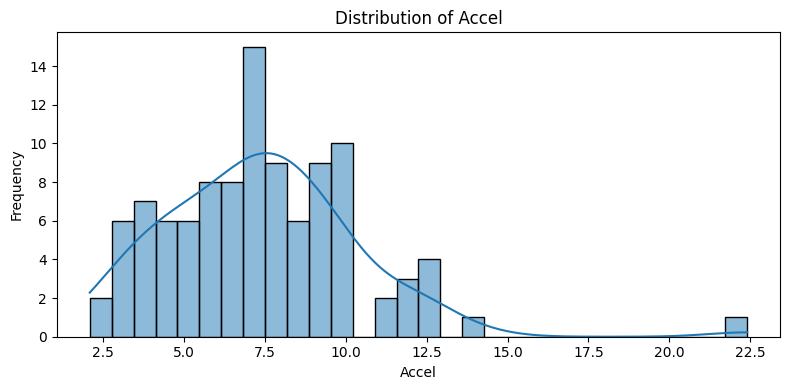

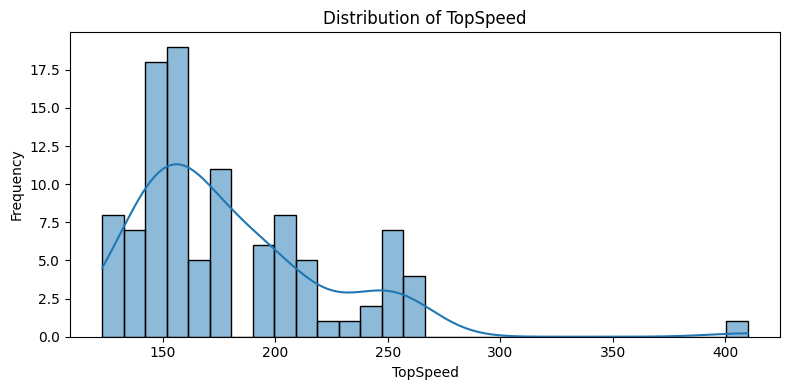

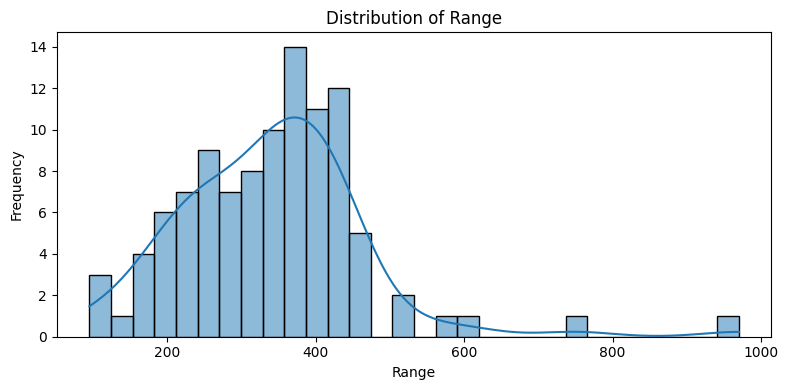

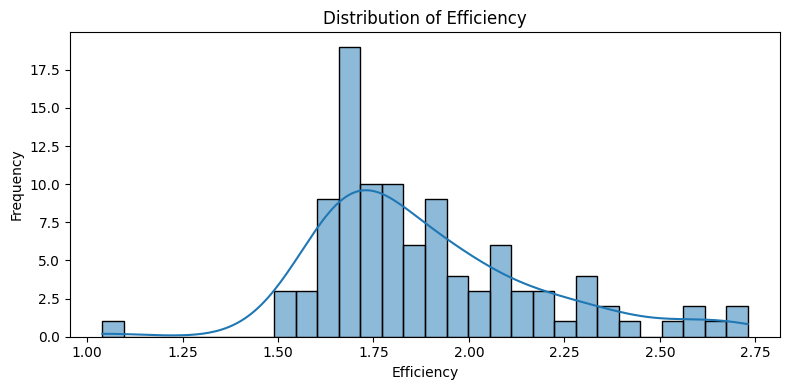

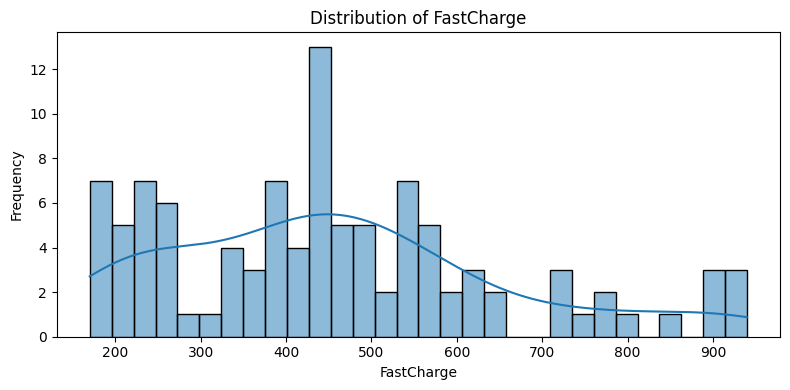

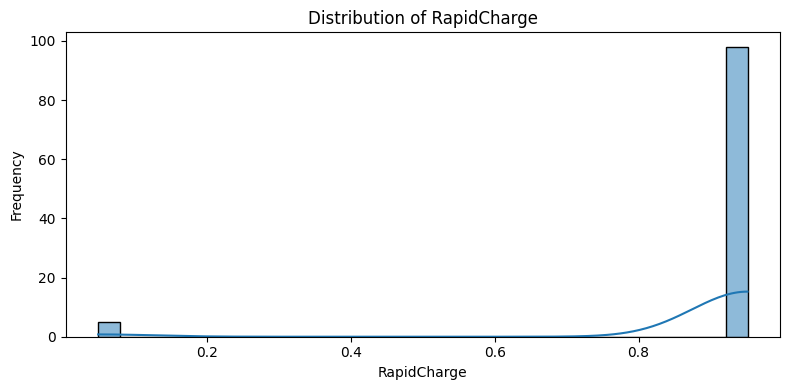

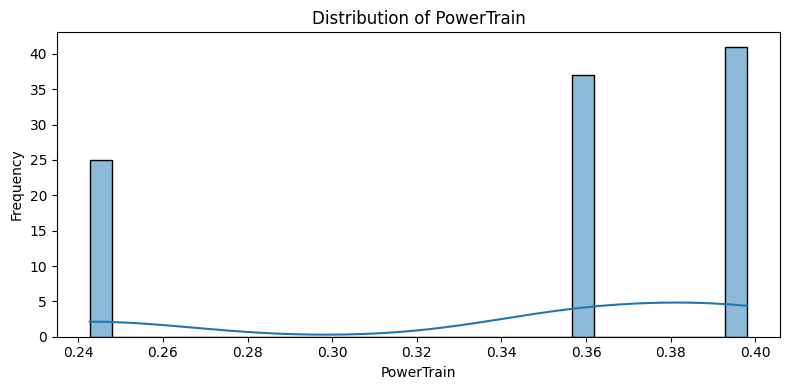

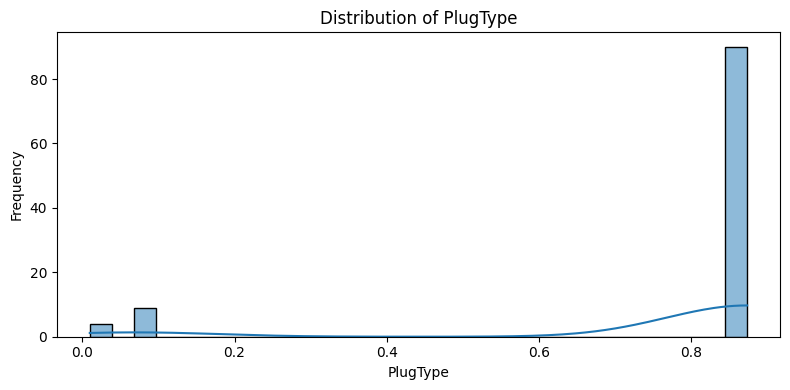

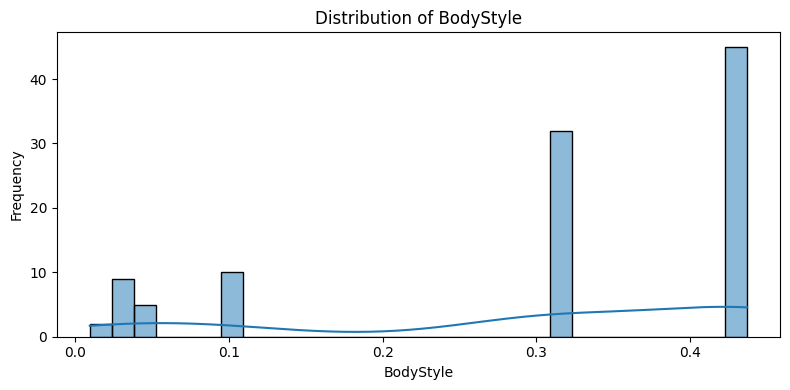

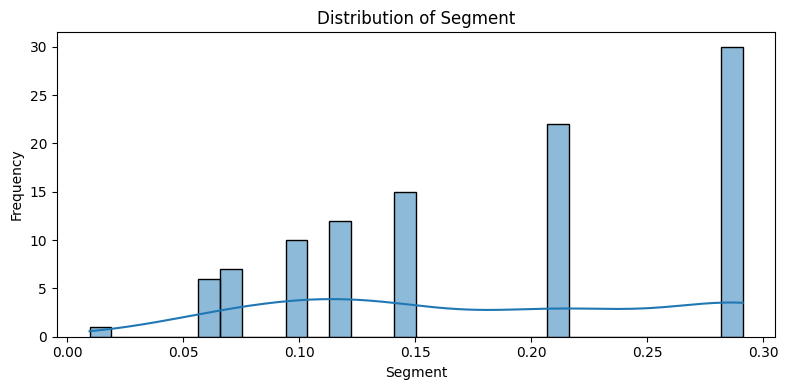

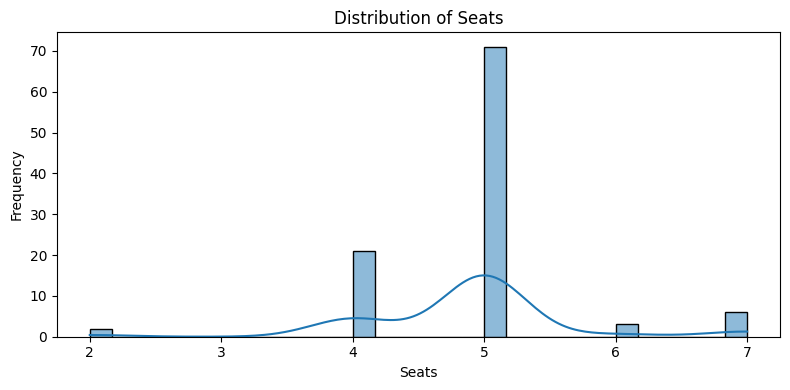

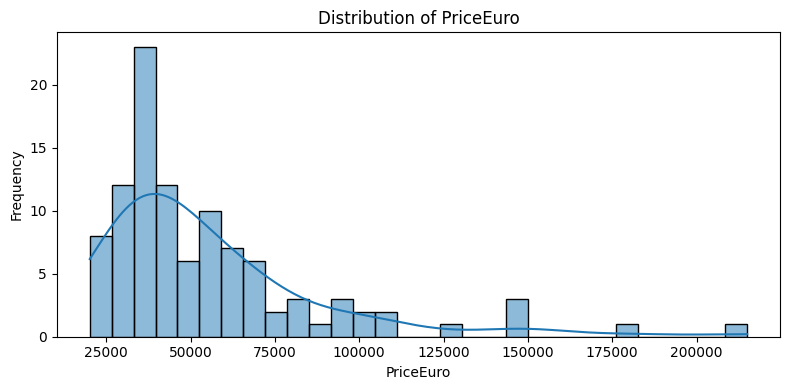

,Accel,TopSpeed,Range,Efficiency,FastCharge,Seats,PriceEuro,Brand,Model,RapidCharge,PowerTrain,PlugType,BodyStyle,Segment
0,4.6,233.0,450.0,1.610,930.0,5.0,55480.0,0.126214,0.009709,0.951456,0.398058,0.873786,0.097087,0.145631
1,10.0,160.0,270.0,1.670,250.0,5.0,30000.0,0.077670,0.009709,0.951456,0.300971,0.873786,0.310680,0.291262
2,4.7,210.0,400.0,1.810,620.0,5.0,56440.0,0.009709,0.009709,0.951456,0.398058,0.873786,0.048544,0.145631
3,6.8,180.0,360.0,2.060,560.0,5.0,68040.0,0.038835,0.009709,0.951456,0.300971,0.873786,0.436893,0.145631
4,9.5,145.0,170.0,1.680,190.0,5.0,32997.0,0.019417,0.009709,0.951456,0.300971,0.873786,0.310680,0.213592
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,7.5,160.0,330.0,1.910,440.0,5.0,45000.0,0.077670,0.009709,0.951456,0.359223,0.873786,0.310680,0.291262
99,4.5,210.0,335.0,2.555,540.0,5.0,96050.0,0.087379,0.009709,0.951456,0.398058,0.873786,0.436893,0.097087
100,5.9,200.0,325.0,1.940,440.0,5.0,50000.0,0.077670,0.009709,0.951456,0.398058,0.873786,0.310680,0.291262
101,5.1,200.0,375.0,2.320,450.0,5.0,65000.0,0.077670,0.009709,0.951456,0.398058,0.873786,0.310680,0.291262


In [ ]:
df_numeric = data.select_dtypes(include=[np.number])

summary_table = univariate_summary(df_numeric)
print("=== Univariate Summary ===")
print(summary_table)

for col in df_numeric.columns:
    plt.figure(figsize=(8, 4))
    sns.histplot(df_numeric[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

df_adjusted = adjust_outliers_iqr(final_df)
df_adjusted

In [ ]:
arget_col = 'PriceEuro'

if target_col in df_adjusted.columns:
    X = df_adjusted.drop(columns=[target_col]).copy()
    Y = df_adjusted[target_col]

In [ ]:
print(X)

     Accel  TopSpeed  Range  Efficiency  FastCharge  Seats     Brand  \
0      4.6     233.0  450.0       1.610       930.0    5.0  0.126214   
1     10.0     160.0  270.0       1.670       250.0    5.0  0.077670   
2      4.7     210.0  400.0       1.810       620.0    5.0  0.009709   
3      6.8     180.0  360.0       2.060       560.0    5.0  0.038835   
4      9.5     145.0  170.0       1.680       190.0    5.0  0.019417   
..     ...       ...    ...         ...         ...    ...       ...   
98     7.5     160.0  330.0       1.910       440.0    5.0  0.077670   
99     4.5     210.0  335.0       2.555       540.0    5.0  0.087379   
100    5.9     200.0  325.0       1.940       440.0    5.0  0.077670   
101    5.1     200.0  375.0       2.320       450.0    5.0  0.077670   
102    7.5     190.0  400.0       2.380       480.0    5.0  0.029126   

        Model  RapidCharge  PowerTrain  PlugType  BodyStyle   Segment  
0    0.009709     0.951456    0.398058  0.873786   0.097087  0.

In [ ]:
print(Y)

0      55480.0
1      30000.0
2      56440.0
3      68040.0
4      32997.0
        ...   
98     45000.0
99     96050.0
100    50000.0
101    65000.0
102    62000.0
Name: PriceEuro, Length: 103, dtype: float64


In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=2)

In [ ]:
def plot_box(data, cols, title):
    plt.figure(figsize=(10, 5))
    sns.boxplot(data=data[cols])
    plt.yscale('log')
    plt.title(title)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [ ]:
def cap_outliers(df, columns):
    df_capped = df.copy()
    for col in columns:
        Q1 = df_capped[col].quantile(0.25)
        Q3 = df_capped[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df_capped[col] = df_capped[col].clip(lower=lower_bound, upper=upper_bound)
    return df_capped

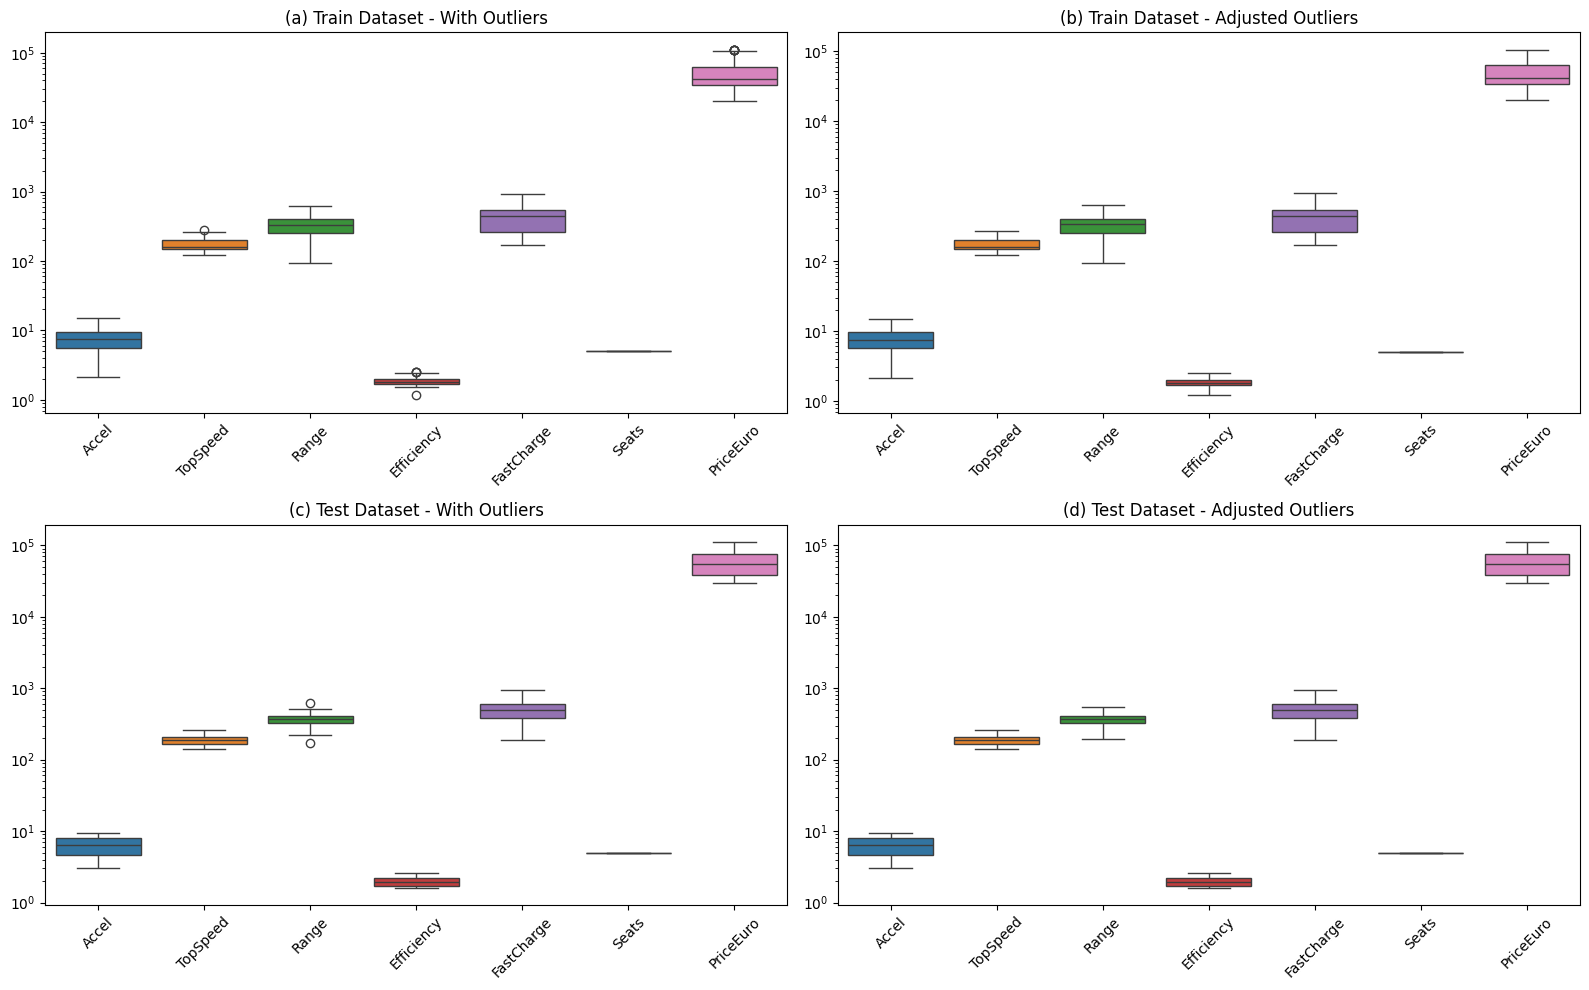

In [ ]:
train_df, test_df = train_test_split(df_adjusted, test_size=0.2, random_state=42)

train_columns_capped = cap_outliers(train_df, num_cols)
test_columns_capped = cap_outliers(test_df, num_cols)

def plot_all_boxplots(train_df, train_capped, test_df, test_capped, cols):
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))

    sns.boxplot(data=train_df[cols], ax=axes[0, 0])
    axes[0, 0].set_title("(a) Train Dataset - With Outliers")
    axes[0, 0].set_yscale('log')
    axes[0, 0].tick_params(axis='x', rotation=45)

    sns.boxplot(data=train_capped[cols], ax=axes[0, 1])
    axes[0, 1].set_title("(b) Train Dataset - Adjusted Outliers")
    axes[0, 1].set_yscale('log')
    axes[0, 1].tick_params(axis='x', rotation=45)

    sns.boxplot(data=test_df[cols], ax=axes[1, 0])
    axes[1, 0].set_title("(c) Test Dataset - With Outliers")
    axes[1, 0].set_yscale('log')
    axes[1, 0].tick_params(axis='x', rotation=45)

    sns.boxplot(data=test_capped[cols], ax=axes[1, 1])
    axes[1, 1].set_title("(d) Test Dataset - Adjusted Outliers")
    axes[1, 1].set_yscale('log')
    axes[1, 1].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

plot_all_boxplots(train_df, train_columns_capped, test_df, test_columns_capped, num_cols)

In [ ]:
print(X_train)

     Accel  TopSpeed  Range  Efficiency  FastCharge  Seats     Brand  \
11     7.9     144.0  220.0        1.64       230.0    5.0  0.077670   
87     6.8     190.0  295.0        2.19       470.0    5.0  0.087379   
57    12.6     135.0  130.0        1.64       440.0    5.0  0.048544   
100    5.9     200.0  325.0        1.94       440.0    5.0  0.077670   
5      2.8     250.0  610.0        1.80       620.0    5.0  0.009709   
..     ...       ...    ...         ...         ...    ...       ...   
43    12.3     130.0  195.0        1.66       170.0    5.0  0.058252   
22    10.0     160.0  290.0        1.79       230.0    5.0  0.058252   
72     3.5     250.0  385.0        2.17       770.0    5.0  0.048544   
15     7.9     160.0  440.0        1.75       590.0    5.0  0.077670   
40     3.8     250.0  515.0        1.84       560.0    5.0  0.126214   

        Model  RapidCharge  PowerTrain  PlugType  BodyStyle   Segment  
11   0.009709     0.951456    0.359223  0.873786   0.310680  0.

In [ ]:
print(X.shape, X_train.shape, X_test.shape)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print(X_train_scaled)

(103, 13) (82, 13) (21, 13)
[[ 7.35204023e-02 -8.11285369e-01 -9.46233171e-01 ...  2.22044605e-16
  -2.30541468e-02  1.21798837e+00]
 [-3.44873307e-01  5.13462861e-01 -2.86070494e-01 ...  2.22044605e-16
   8.24384492e-01 -1.02136244e+00]
 [ 1.86120261e+00 -1.07047524e+00 -1.73842838e+00 ...  2.22044605e-16
  -2.30541468e-02 -1.35726507e+00]
 ...
 [-1.60005443e+00  2.24139533e+00  5.06124720e-01 ...  2.22044605e-16
  -2.04386936e+00 -7.97427363e-01]
 [ 7.35204023e-02 -3.50503376e-01  9.90244017e-01 ...  2.22044605e-16
  -2.30541468e-02  1.21798837e+00]
 [-1.48594706e+00  2.24139533e+00  1.65040669e+00 ...  2.22044605e-16
  -1.78311901e+00 -7.97427363e-01]]


**MODEL TRAINING**

**LINEAR REGRESSION**

In [ ]:
model = LinearRegression()
model.fit(X_train, Y_train)

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

mae = mean_absolute_error(Y_test, y_test_pred)
mse = mean_squared_error(Y_test, y_test_pred)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(Y_test, y_test_pred) * 100
accuracy = 100 - mape
train_r2 = r2_score(Y_train, y_train_pred)
test_r2 = r2_score(Y_test, y_test_pred)

print("\n=== Linear Regression Results ===")
print(f"Training R²: {train_r2:.2f}")
print(f"Testing R²: {test_r2:.2f}")
print(f"Mean Absolute Error: {mae:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")
print(f"Mean Squared Error: {mse:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"Testing Accuracy: {accuracy:.2f}%")

if train_r2 < 0.5 and test_r2 < 0.5:
    print("\nModel is underfitting (Poor performance on all metrics)")
elif abs(train_r2 - test_r2) < 0.05:
    print("\nModel is well-fitted")
elif train_r2 > test_r2 + 0.1:
    print("\nModel is overfitting (Training R² > Test R²)")
else:
    print("\nModel shows mixed behavior")


=== Linear Regression Results ===
Training R²: 0.84
Testing R²: 0.73
Mean Absolute Error: 11738.91
Root Mean Squared Error: 14224.25
Mean Squared Error: 202329312.20
MAPE: 22.64%
Testing Accuracy: 77.36%

Model is overfitting (Training R² > Test R²)


**ORIGINAL GBM**

In [ ]:
gbm_model = GradientBoostingRegressor(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=5,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42
)

gbm_model.set_params(
    n_iter_no_change=10,
    validation_fraction=0.2
)

scores = cross_val_score(gbm_model, X_train_scaled, Y_train,
                        cv=5, scoring='r2', n_jobs=-1)

gbm_model.fit(X_train_scaled, Y_train)

y_train_pred = gbm_model.predict(X_train_scaled)
y_test_pred = gbm_model.predict(X_test_scaled)

metrics = {
    'MAE': mean_absolute_error(Y_test, y_test_pred),
    'MSE': mean_squared_error(Y_test, y_test_pred),
    'RMSE': np.sqrt(mean_squared_error(Y_test, y_test_pred)),
    'R²': r2_score(Y_test, y_test_pred),
    'MAPE': mean_absolute_percentage_error(Y_test, y_test_pred) * 100
}
metrics['Accuracy'] = 100 - metrics['MAPE']
train_r2 = r2_score(Y_train, y_train_pred)
test_r2 = r2_score(Y_test, y_test_pred)

print("==== Gradient Boosting Results ====")
print(f"MAE: {metrics['MAE']:.2f}")
print(f"MSE: {metrics['MSE']:.2f}")
print(f"RMSE: {metrics['RMSE']:.2f}")
print(f"R²: {metrics['R²']:.2f}")
print(f"Accuracy: {metrics['Accuracy']:.2f}%")
print(f"Mean CV R²: {scores.mean():.2f} (±{scores.std():.2f})")

if train_r2 < 0.5 and test_r2 < 0.5:
    print("\nModel is underfitting (Poor performance on all metrics)")
elif abs(train_r2 - test_r2) < 0.05:
    print("\nModel is well-fitted")
elif train_r2 > test_r2 + 0.1:
    print("\nModel is overfitting (Training R² > Test R²)")
else:
    print("\nModel shows mixed behavior")


==== Gradient Boosting Results ====
MAE: 7798.68
MSE: 107115928.75
RMSE: 10349.68
R²: 0.86
Accuracy: 86.50%
Mean CV R²: 0.61 (±0.17)

Model is well-fitted


OPTIMIZED GBM

In [ ]:
X_train_df = pd.DataFrame(X_train_scaled)
y_train_series = pd.Series(Y_train)
model.fit(X_train_scaled, Y_train)

y_pred = model.predict(X_test_scaled)
X_cleaned = adjust_outliers_iqr(X_train_df)
y_cleaned = y_train_series
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}

grid_search = GridSearchCV(
    GradientBoostingRegressor(random_state=42),
    param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1
)

grid_search.fit(X_cleaned, y_cleaned)
best_gbm = grid_search.best_estimator_

y_train_pred = best_gbm.predict(X_cleaned)
train_r2 = r2_score(y_cleaned, y_train_pred)

y_test_pred = best_gbm.predict(X_test_scaled)
metrics = {
    'MAE': mean_absolute_error(Y_test, y_test_pred),
    'MSE': mean_squared_error(Y_test, y_test_pred),
    'RMSE': np.sqrt(mean_squared_error(Y_test, y_test_pred)),
    'MAPE': mean_absolute_percentage_error(Y_test, y_test_pred) * 100
}
metrics['Accuracy'] = 100 - metrics['MAPE']

train_r2 = r2_score(Y_train, y_train_pred)
test_r2 = r2_score(Y_test, y_test_pred)
cv_scores = cross_val_score(best_gbm, X_cleaned, y_cleaned, cv=5, scoring='r2')

print("\n==== Optimized Gradient Boosting Results ====")
print(f"Best Parameters: {grid_search.best_params_}")
for metric, value in metrics.items():
    print(f"{metric}: {value:.2f}" + ("%" if metric in ['MAPE', 'Accuracy'] else ""))
print(f"\nTraining R²: {train_r2:.2f}")
print(f"Testing R²: {test_r2:.2f}")
print(f"Cross-Validation R² Scores: {cv_scores}")
print(f"Mean CV R²: {cv_scores.mean():.2f}")

if train_r2 < 0.5 and test_r2 < 0.5:
    print("\nModel is underfitting (Poor performance on all metrics)")
elif abs(train_r2 - test_r2) < 0.05:
    print("\nModel is well-fitted")
elif train_r2 > test_r2 + 0.1:
    print("\nModel is overfitting (Training R² > Test R²)")
else:
    print("\nModel shows mixed behavior")


==== Optimized Gradient Boosting Results ====
Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}
MAE: 4805.63
MSE: 42596353.25
RMSE: 6526.59
MAPE: 8.16%
Accuracy: 91.84%

Training R²: 0.99
Testing R²: 0.94
Cross-Validation R² Scores: [0.54175169 0.73907446 0.78533334 0.48811352 0.90647168]
Mean CV R²: 0.69

Model is well-fitted


**RANDOM** **FOREST**

In [ ]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=0)
rf_model.fit(X_train_scaled, Y_train)

y_pred_rf = rf_model.predict(X_test_scaled)

mae = mean_absolute_error(Y_test, y_pred_rf)
mse = mean_squared_error(Y_test, y_pred_rf)
rmse = np.sqrt(mse)
r2 = r2_score(Y_test, y_pred_rf)
mape = mean_absolute_percentage_error(Y_test, y_pred_rf) * 100
accuracy = 100 - mape

print("==== Random Forest Results ====")
print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.2f}")
print(f"Accuracy: {accuracy:.2f}%")

train_r2 = r2_score(Y_train, y_train_pred)
test_r2 = r2_score(Y_test, y_test_pred)

if train_r2 < 0.5 and test_r2 < 0.5:
    print("\nModel is underfitting (Poor performance on all metrics)")
elif abs(train_r2 - test_r2) < 0.05:
    print("\nModel is well-fitted")
elif train_r2 > test_r2 + 0.1:
    print("\nModel is overfitting (Training R² > Test R²)")
else:
    print("\nModel shows mixed behavior")

==== Random Forest Results ====
MAE: 7971.44
MSE: 106146535.59
RMSE: 10302.74
R² Score: 0.86
Accuracy: 86.94%

Model is well-fitted


**KNN**

In [ ]:
!apt-get install libgomp1

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libgomp1 is already the newest version (12.3.0-1ubuntu1~22.04).
libgomp1 set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


In [ ]:
param_grid = {'n_neighbors': range(3, 20)}
grid_search = GridSearchCV(KNeighborsRegressor(), param_grid, cv=5, scoring='r2')
grid_search.fit(X_train_scaled, Y_train)

best_k = grid_search.best_params_['n_neighbors']
knn_model = KNeighborsRegressor(n_neighbors=best_k)
knn_model.fit(X_train_scaled, Y_train)

y_pred_knn = knn_model.predict(X_test_scaled)

mae = mean_absolute_error(Y_test, y_pred_knn)
mse = mean_squared_error(Y_test, y_pred_knn)
rmse = np.sqrt(mse)
r2 = r2_score(Y_test, y_pred_knn)
mape = mean_absolute_percentage_error(Y_test, y_pred_knn) * 100
accuracy = 100 - mape

print("==== Optimized KNN Results ====")
print(f"Best k: {best_k}")
print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.2f}")
print(f"Accuracy: {accuracy:.2f}%")

train_r2 = r2_score(Y_train, y_train_pred)
test_r2 = r2_score(Y_test, y_test_pred)

if train_r2 < 0.5 and test_r2 < 0.5:
    print("\nModel is underfitting (Poor performance on all metrics)")
elif abs(train_r2 - test_r2) < 0.05:
    print("\nModel is well-fitted")
elif train_r2 > test_r2 + 0.1:
    print("\nModel is overfitting (Training R² > Test R²)")
else:
    print("\nModel shows mixed behavior")


==== Optimized KNN Results ====
Best k: 3
MAE: 9622.06
MSE: 247915918.75
RMSE: 15745.35
R² Score: 0.67
Accuracy: 83.76%

Model is well-fitted


**XGBoost**

In [ ]:
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=0)
xgb_model.fit(X_train_scaled, Y_train)

y_pred_xgb = xgb_model.predict(X_test_scaled)

mae = mean_absolute_error(Y_test, y_pred_xgb)
mse = mean_squared_error(Y_test, y_pred_xgb)
rmse = np.sqrt(mse)
r2 = r2_score(Y_test, y_pred_xgb)
mape = mean_absolute_percentage_error(Y_test, y_pred_xgb) * 100
accuracy = 100 - mape

print("==== XGBoost Results ====")
print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.2f}")
print(f"Accuracy: {accuracy:.2f}%")

train_r2 = r2_score(Y_train, y_train_pred)
test_r2 = r2_score(Y_test, y_test_pred)

if train_r2 < 0.5 and test_r2 < 0.5:
    print("\nModel is underfitting (Poor performance on all metrics)")
elif abs(train_r2 - test_r2) < 0.05:
    print("\nModel is well-fitted")
elif train_r2 > test_r2 + 0.1:
    print("\nModel is overfitting (Training R² > Test R²)")
else:
    print("\nModel shows mixed behavior")

==== XGBoost Results ====
MAE: 5970.86
MSE: 58407968.41
RMSE: 7642.51
R² Score: 0.92
Accuracy: 90.61%

Model is well-fitted


**HYBRID MODEL**

In [ ]:
pip install xgboost lightgbm scikit-learn

In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.1 MB/s eta 0:00:00


In [ ]:
import warnings
warnings.filterwarnings('ignore')

xgb_model = XGBRegressor(n_estimators=500, learning_rate=0.05, max_depth=7, subsample=0.8, colsample_bytree=0.8, random_state=42)
gbm_model = GradientBoostingRegressor(n_estimators=500, learning_rate=0.05, max_depth=7, subsample=0.8, random_state=42)
lgb_model = LGBMRegressor(n_estimators=500, learning_rate=0.05, max_depth=7, subsample=0.8, colsample_bytree=0.8, random_state=42)

xgb_model.fit(X_train_scaled, Y_train)
gbm_model.fit(X_train_scaled, Y_train)
lgb_model.fit(X_train_scaled, Y_train)

xgb_pred_train = xgb_model.predict(X_train_scaled)
gbm_pred_train = gbm_model.predict(X_train_scaled)
lgb_pred_train = lgb_model.predict(X_train_scaled)

xgb_pred_test = xgb_model.predict(X_test_scaled)
gbm_pred_test = gbm_model.predict(X_test_scaled)
lgb_pred_test = lgb_model.predict(X_test_scaled)

meta_train = np.column_stack((xgb_pred_train, gbm_pred_train, lgb_pred_train))
meta_test = np.column_stack((xgb_pred_test, gbm_pred_test, lgb_pred_test))

meta_model = XGBRegressor(n_estimators=300, learning_rate=0.03, max_depth=5, random_state=42)
meta_model.fit(meta_train, Y_train)

final_predictions = meta_model.predict(meta_test)

y_true = np.concatenate((Y_train, Y_test), axis=0)
y_pred = np.concatenate((meta_model.predict(meta_train), meta_model.predict(meta_test)), axis=0)

kf = KFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(model, X_train_scaled, Y_train, cv=kf, scoring='r2')
print("R² Scores for each fold:", scores)
print("Average R² Score:", np.mean(scores))

total_rmse = mean_squared_error(y_true, y_pred) ** 0.5
total_mae = mean_absolute_error(y_true, y_pred)  # MAE
total_mse = mean_squared_error(y_true, y_pred)  # MSE
total_r2 = r2_score(y_true, y_pred)  # R² Score
total_mape = mean_absolute_percentage_error(y_true, y_pred)  # MAPE

train_acc = meta_model.score(meta_train, Y_train)
test_acc = meta_model.score(meta_test, Y_test)

print("Total RMSE:", total_rmse)
print("Total MAE:", total_mae)
print("Total MSE:", total_mse)
print("Total R² Score:", total_r2)
print("Total MAPE:", total_mape)

accuracy = 100 - (total_mape * 100)
print("Overall Model Accuracy:", accuracy, "%")

train_r2 = r2_score(Y_train, y_train_pred)
test_r2 = r2_score(Y_test, y_test_pred)

print("Training R2: ", train_r2)
print("Testing R2: ", test_r2)

if train_r2 < 0.5 and test_r2 < 0.5:
    print("\nModel is underfitting")
elif abs(train_r2 - test_r2) < 0.05 and train_r2 > 0.5 and test_r2 > 0.5:
    print("\nModel is well-fitted")
elif train_r2 > test_r2 + 0.1:
    print("\nModel is overfitting")
else:
    print("\nModel shows mixed behavior")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000246 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 133
[LightGBM] [Info] Number of data points in the train set: 82, number of used features: 9
[LightGBM] [Info] Start training from score 50341.173780
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 